# 🎮 Deep RL Final Project — MiniGrid Environments

## Overview
In this project, you will train deep RL agents on two MiniGrid environments. You must implement the core algorithms yourself using concepts from class.

**Read first:** Follow the instructions in the accompanying PDF. This notebook defines the environment APIs and where you may edit.

## Learning objectives
- Implement deep RL from scratch.
- Design observation preprocessing and reward shaping.
- Evaluate performance with clear metrics and plots.
- Communicate results in a concise report.

## 🌍 The Two Environments
| Environment | Description | Actions | Goal |
|-------------|-------------|---------|------|
| **`SimpleGridEnv`** | 8×8 empty room | 3 (Left, Right, Forward) | Navigate to the green goal square |
| **`KeyDoorBallEnv`** | Two rooms with locked door | 5 (Left, Right, Forward, Pickup, Toggle) | Get key → Open door → Pick up ball → Reach goal |

## ✅ What You CAN Modify
- **Preprocessing** — Implement your own observation preprocessing function.
- **Reward shaping** — Modify rewards in each `step()` method (see `# TODO`).
- **Observation space** — Update `self.observation_space` to match preprocessing output.

## ❌ What You CANNOT Modify
- Grid layout and generation logic.
- Action spaces or termination conditions.
- Environment mechanics (door/key/ball rules).
- **No external RL libraries** for the core algorithm (you may use PyTorch/TensorFlow).

## 📦 Deliverables & Submission
**Submit:** (1) this notebook with your full code and outputs, and (2) a report formatted **as specified in the instructions PDF**.

## 🧪 Reproducibility checklist
- Set random seeds for Python, NumPy, and your DL framework.
- Document hyperparameters.

## 🧾 Academic integrity
- You may discuss ideas, but code and write-up must be your own.
- Cite any external resources (blog posts, papers, code snippets).
---

# Setup

## Installs and Imports

### Installs (run once if needed)

In [40]:
# TODO: restore before submission
# %%capture
# !sudo apt-get update
# !sudo apt-get install -y xvfb ffmpeg freeglut3-dev
# !pip install imageio
# !pip install pyvirtualdisplay
# !pip install gymnasium
# !pip install minigrid
# !pip install pygame

### Imports

In [41]:
# 1. Future Imports (Must be first)
from __future__ import annotations

# 2. Standard Library Imports
import base64
import copy
import random

# 3. Third-Party Data & Visualization Imports
import imageio
import matplotlib.pyplot as plt
import numpy as np
import IPython
from IPython.display import HTML
import pyvirtualdisplay

# 4. Gymnasium Imports
import gymnasium as gym
from gymnasium import spaces

# 5. Minigrid Imports
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Lava, Wall, Ball
from minigrid.minigrid_env import MiniGridEnv as BaseMiniGridEnv

# --- Configuration ---

# Configure Matplotlib for Notebook Environment
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Display utils
The cell below contains the video display configuration. No need to make changes here.

In [42]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

# COLAB ONLY — restore before submission (Xvfb not available on macOS)
# display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Environments

> ⚠️ **Important**
>
> The two environments below are **fixed**—do not modify grid layout, action spaces, or termination conditions.
>
> **You may modify only:**
> 1. **Observation space** — set `self.observation_space` to match your preprocessing output (see `# TODO`).
> 2. **Reward shaping** — edit reward logic inside `step()` (see `# TODO`).
>
> Look for the clearly marked sections in each environment class.

In [43]:
# =============================================================================
# ENVIRONMENT 1: SIMPLE GRID (Empty Room)
# =============================================================================
class SimpleGridEnv(BaseMiniGridEnv):
    """
    A simple grid environment with no obstacles inside, just outer walls.
    The agent and goal positions are randomized at each reset.

    Actions:
        0: Turn Left
        1: Turn Right
        2: Move Forward
    """
    def __init__(
        self,
        size=10,
        max_steps=1000,
        render_mode="rgb_array",
        preprocess=None,
        **kwargs,
    ):

        # Define a static mission string (not used by the agent typically)
        mission_space = MissionSpace(mission_func=self._gen_mission)


        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            see_through_walls=True,
            max_steps=max_steps,
            render_mode=render_mode,
            highlight=False,
            **kwargs,
        )
        # Discrete actions: 0: Turn Left, 1: Turn Right, 2: Move Forward
        self.action_space = spaces.Discrete(3)

        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║  ✅ STUDENT TODO: Update observation_space to match preprocessing   ║
        # ╚═════════════════════════════════════════════════════════════════════╝
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(84, 84, 3),
            dtype=np.uint8
        )
        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║                     END OF EDITABLE SECTION                         ║
        # ╚═════════════════════════════════════════════════════════════════════╝

        # Preprocessing function for observations
        self.preprocess = preprocess if preprocess is not None else lambda x: x
        self.walls_init = []
        # Default goal and agent starting position (overwritten in _gen_grid)
        self.goal_pos = (self.width - 2, self.height - 2)
        self.agent_start_pos = (1, 1)
        self.agent_start_dir = 0


    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ⛔ DO NOT MODIFY: Core environment methods below                       ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _get_obs(self, obs=None):
        """Returns the current observation after applying preprocessing."""
        obs = self.get_frame(highlight=False, tile_size=32)
        return self.preprocess(obs)

    def reset(self, *, seed=None, options=None):
        # 1. Randomize agent starting parameters before generating the grid
        self.agent_start_pos = (random.randint(1, 6), random.randint(1, 6))
        self.agent_start_dir = random.choice([0, 1, 2, 3])
        # 2. Call parent reset, which internally calls _gen_grid()
        obs, info = super().reset(seed=seed, options=options)
        # 3. Return the preprocessed observation
        return self._get_obs(obs), info

    def _gen_grid(self, width, height):
        """Procedurally generates the grid layout: walls, goal, and agent."""
        self.grid = Grid(width, height)

        # 1. Create the outer boundary walls
        self.grid.wall_rect(0, 0, width, height)

        # 2. Place internal walls (if any defined in self.walls_init)
        for column, row in self.walls_init:
            self.grid.set(column, row, Wall())

        # 3. Randomize Goal Position (Top-Right, Bottom-Right, Bottom-Left corners roughly)
        self.goal_pos = random.choice([(8,1), (8,8), (1,8)])
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # 4. Place Agent
        self.agent_pos = self.agent_start_pos
        self.agent_dir = self.agent_start_dir

        self.mission = "grand mission"

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ✅ STUDENT TODO: Modify reward shaping below                           ║
    # ╚═════════════════════════════════════════════════════════════════════════╝
    def step(self, action):
        """
        Reward shaping (no distance signals — only discrete events & step penalty):

            +5.0   reaching the goal  (large so it clearly dominates step costs)
            -0.01  per step           (light penalty — 100-step fail = -1.0)
            -0.03  wall bump          (forward action that doesn't move the agent)

        With max_steps ≈ 100 a random agent finds the goal ~17 % of the time,
        giving enough positive-reward episodes for A2C to bootstrap from.
        A successful 40-step episode scores  -0.01*40 + 5.0 = +4.6,
        while a 100-step failure scores  -0.01*100 = -1.0.
        """
        pos_before = tuple(self.agent_pos)

        obs, reward, terminated, truncated, info = super().step(action)

        # ----- REWARD SHAPING: EDIT BELOW THIS LINE -----
        if terminated:
            reward = 5.0
        else:
            reward = -0.01  # step penalty

            # Wall bump: agent tried to move forward but didn't change position
            if action == 2 and tuple(self.agent_pos) == pos_before:
                reward = -0.03
        # ----- REWARD SHAPING: EDIT ABOVE THIS LINE -----

        return self._get_obs(obs), reward, terminated, truncated, info
    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║                     END OF EDITABLE SECTION                             ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

In [44]:
# =============================================================================
# ENVIRONMENT 2: KEY-DOOR WITH BALL PICKUP
# =============================================================================
class KeyDoorBallEnv(BaseMiniGridEnv):
    """
    Grid environment with two rooms separated by a locked door.

    Task sequence:
        1. Pick up key -> 2. Unlock door -> 3. Pick up ball -> 4. Reach goal

    Actions:
        0: Turn Left
        1: Turn Right
        2: Move Forward
        3: Pick Up
        4: Toggle (open/close door)
    """
    def __init__(
        self,
        size=10,
        max_steps=1000,
        render_mode="rgb_array",
        partition_col=3,
        require_ball_pickup=True,
        preprocess=None,
        **kwargs,
    ):
        self.agent_start_pos = (1, 1)
        self.agent_start_dir = 0
        self.partition_col = partition_col
        self.walls_init = []
        self.inventory = []
        self.require_ball_pickup = require_ball_pickup
        self.preprocess = preprocess if preprocess is not None else lambda x: x

        mission_space = MissionSpace(mission_func=self._gen_mission)
        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            see_through_walls=True,
            max_steps=max_steps,
            render_mode=render_mode,
            highlight=False,
            **kwargs,
        )

        # 5 actions: left, right, forward, pickup, toggle
        self.action_space = spaces.Discrete(5)

        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║  ✅ STUDENT TODO: Update observation_space to match preprocessing   ║
        # ╚═════════════════════════════════════════════════════════════════════╝
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(84, 84, 3),
            dtype=np.uint8
        )
        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║                     END OF EDITABLE SECTION                         ║
        # ╚═════════════════════════════════════════════════════════════════════╝

        # State tracking for reward shaping (you can use these in your reward logic)
        self.prev_key = False
        self.prev_door = False
        self.prev_ball = False

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ⛔ DO NOT MODIFY: Core environment methods below                       ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    @staticmethod
    def _gen_mission():
        return "Pick up the key to open the door, pick up the ball, then reach the goal"

    def _get_obs(self, obs=None):
        """Returns the current observation after applying preprocessing."""
        obs = self.get_frame(highlight=False, tile_size=32)
        return self.preprocess(obs)

    def reset(self, *, seed=None, options=None):
        # Reset state tracking
        self.prev_key = False
        self.prev_door = False
        self.prev_ball = False
        self.inventory = []

        # Call parent reset, which internally calls _gen_grid()
        obs, info = super().reset(seed=seed, options=options)

        return self._get_obs(obs), info

    def _gen_grid(self, width, height):
        """Generate grid: walls, partition, door, key, ball, goal, agent."""
        # Grid with outer walls
        self.grid = Grid(width, height)
        self.grid.wall_rect(0, 0, width, height)

        # Partition wall
        self.walls_init = [(self.partition_col, i) for i in range(height)]
        for col, row in self.walls_init:
            if 0 <= col < width and 0 <= row < height:
                self.grid.set(col, row, Wall())

        # Key in left room
        self.key_pos = (
            random.choice(range(1, self.partition_col)),
            random.choice(range(2, height - 1))
        )
        self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))

        # Door in partition
        door_y = random.choice(range(1, height - 1))
        self.door_pos = (self.partition_col, door_y)
        self.env_door = Door(COLOR_NAMES[0], is_locked=True)
        self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)

        # Goal
        self.goal_pos = (8, 8)
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Ball in right room (if required)
        if self.require_ball_pickup:
            right_x = range(self.partition_col + 2, width - 2)
            right_y = range(1, height - 1)
            while True:
                ball_x = random.choice(list(right_x))
                ball_y = random.choice(list(right_y))
                self.ball_pos = (ball_x, ball_y)
                if self.ball_pos != self.goal_pos:
                    break

            self.grid.set(ball_x, ball_y, Ball(COLOR_NAMES[1]))

        # Agent
        self.agent_pos = self.agent_start_pos
        self.agent_dir = self.agent_start_dir

    def try_pickup_ball(self):
        """Pick up ball in front and add to inventory."""
        obj = self.grid.get(self.front_pos[0], self.front_pos[1])
        if isinstance(obj, Ball):
            self.grid.set(self.front_pos[0], self.front_pos[1], None)
            self.inventory.append(obj)

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ✅ STUDENT TODO: Modify reward shaping below                           ║
    # ╚═════════════════════════════════════════════════════════════════════════╝
    def step(self, action):
        """
        Step function with sparse reward.

        Available helper methods for reward shaping:
            - self.is_carrying_key()  : Returns True if agent has the key
            - self.is_carrying_ball() : Returns True if agent has the ball
            - self.is_door_open()     : Returns True if door is open
            - self.prev_key           : Key status before this step
            - self.prev_door          : Door status before this step
            - self.prev_ball          : Ball status before this step

        Current reward scheme (sparse):
            - +1.0 for reaching goal with ball
            - 0.0 otherwise

        💡 You can add reward shaping here
        """
        # Map action 4 to toggle (internal MiniGrid uses 5 for toggle)
        if action == 4:
            action = 5

        # Track previous state for reward shaping
        self.prev_key = self.is_carrying_key()
        self.prev_door = self.is_door_open()
        self.prev_ball = self.is_carrying_ball()

        # Handle ball pickup
        if action == 3:
            self.try_pickup_ball()

        # Standard step
        obs, reward, terminated, truncated, info = super().step(action)

        # Goal only counts if ball is picked up (when required)
        terminated = terminated and (not self.require_ball_pickup or self.is_carrying_ball())

        # ----- REWARD SHAPING: EDIT BELOW THIS LINE -----
        if terminated:
            reward = 1.0
        else:
            reward = 0.0
        # ----- REWARD SHAPING: EDIT ABOVE THIS LINE -----

        return self._get_obs(obs), reward, terminated, truncated, info
    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║                     END OF EDITABLE SECTION                             ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ⛔ DO NOT MODIFY: State getter methods (use these in reward shaping)   ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    def is_carrying_key(self):
        """Check if agent has key (in hand or inventory)."""
        key_in_hand = self.carrying and isinstance(self.carrying, Key)
        key_in_inventory = any(isinstance(item, Key) for item in self.inventory)
        return key_in_hand or key_in_inventory

    def is_carrying_ball(self):
        """Check if agent has ball (in hand or inventory)."""
        ball_in_hand = self.carrying and isinstance(self.carrying, Ball)
        ball_in_inventory = any(isinstance(item, Ball) for item in self.inventory)
        return ball_in_hand or ball_in_inventory

    def is_door_open(self):
        """Returns True if the door is open."""
        if hasattr(self, 'env_door'):
            return self.env_door.is_open
        return False

# Preprocessing Method

> 💡 **Student task:** Implement your own preprocessing function below.
>
> Your preprocessing function should:
> 1. Take a raw RGB image (320×320×3) as input.
> 2. Return a processed observation that **exactly matches** your `observation_space` (shape, dtype, value range).
>
> Common preprocessing techniques:
> - Crop edges to remove borders
> - Convert to grayscale
> - Resize to smaller dimensions
> - Normalize pixel values
>
> **Reminder:** Update `self.observation_space` in both environment classes to match your output.

In [45]:
import cv2

def pre_process(img):
    """
    Default preprocessing function:
        1. Crop the outer wall frame (1 cell from each edge of the 10×10 grid)
        2. Resize to 84×84
        3. Keep RGB (3 channels) — colour is critical for distinguishing
           the red agent from the green goal.

    Args:
        img: RGB image from MiniGrid renderer, shape (H, W, 3).
             H = W = grid_size * tile_size  (e.g. 320 for tile_size=32).

    Returns:
        RGB image (84, 84, 3) with values 0–255 (uint8).
    """
    h, w = img.shape[:2]

    # 1. Crop outer wall frame: 1/10 margin on each side (for 10×10 grid)
    margin = h // 10
    cropped = img[margin : h - margin, margin : w - margin]

    # 2. Resize to 84×84 (keep RGB)
    resized = cv2.resize(cropped, (84, 84), interpolation=cv2.INTER_AREA)

    return resized  # (84, 84, 3)

# 🔍 Environment Examples & Exploration
Run the cells below to understand each environment before implementing your solution.
Use these quick tests to verify preprocessing output shape and rendering.

## Environment 1: SimpleGridEnv (Empty Room)

**Task**: Navigate to the green goal square in an empty 8×8 room.

| Property | Value |
|----------|-------|
| Grid Size | 8×8 |
| Agent Start | Random position (1-6, 1-6) |
| Agent Direction | Random (0-3) |
| Goal Position | Random: (8,1), (1,8), or (8,8) |
| Actions | 0: Turn Left, 1: Turn Right, 2: Move Forward |
| Sparse Reward | +1.0 on reaching goal, 0.0 otherwise |

### Quick Test

=== SimpleGridEnv ===
Action space:       Discrete(3)
Number of actions:  3
Observation space:  Box(0, 255, (84, 84, 3), uint8)  (ensure it matches preprocessing output)
Observation shape:  (84, 84, 3)
Agent direction:    0
Agent position:     (2, 6)
Goal position:      (8, 1)


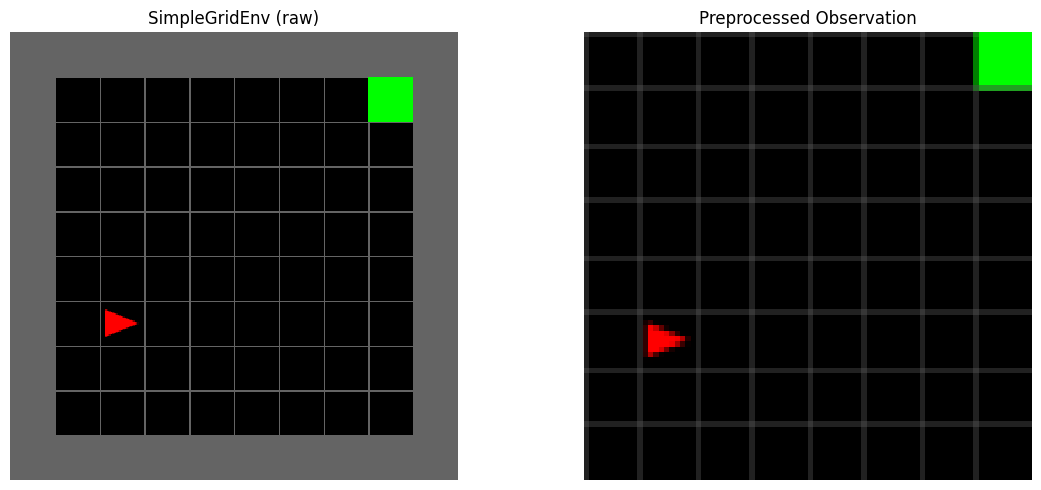

In [46]:
# Initialize environment with preprocessing
env = SimpleGridEnv(max_steps=100, preprocess=pre_process)
obs = env.reset()[0]

print("=== SimpleGridEnv ===")
print(f"Action space:       {env.action_space}")
print(f"Number of actions:  {env.action_space.n}")
print(f"Observation space:  {env.observation_space}  (ensure it matches preprocessing output)")
print(f"Observation shape:  {obs.shape}")
print(f"Agent direction:    {env.agent_dir}")
print(f"Agent position:     {env.agent_pos}")
print(f"Goal position:      {env.goal_pos}")

# Side-by-side view of raw and preprocessed observations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(env.render())
axes[0].set_title("SimpleGridEnv (raw)")
axes[0].axis("off")
axes[1].imshow(obs.squeeze(), cmap="gray")
axes[1].set_title("Preprocessed Observation")
axes[1].axis("off")
plt.tight_layout()
plt.show()

## Environment 2: KeyDoorBallEnv (Key-Door-Ball Task)

**Task**: Complete a multi-step objective: Key → Door → Ball → Goal

| Property | Value |
|----------|-------|
| Grid Size | 8×8 (two rooms) |
| Partition Wall | Column 3 |
| Key Location | Left room (random) |
| Door Location | In partition wall (random row) |
| Ball Location | Right room (random) |
| Goal Position | Fixed at (8, 8) |
| Actions | 0: Left, 1: Right, 2: Forward, 3: Pickup, 4: Toggle |

**Sequence**: Pick up key → Open door → Enter right room → Pick up ball → Reach goal

**Helper Methods** (use in reward shaping):
- `is_carrying_key()` — True if agent has the key
- `is_carrying_ball()` — True if agent has the ball
- `is_door_open()` — True if door is open

### Quick Test

=== KeyDoorBallEnv ===
Action space:       Discrete(5)
Number of actions:  5
Observation space:  Box(0, 255, (84, 84, 3), uint8)  (ensure it matches preprocessing output)
Observation shape:  (84, 84, 3)
Agent direction:    0
Agent position:     (1, 1)
Goal position:      (8, 8)
Carrying key:       False
Door open:          False
Carrying ball:      False


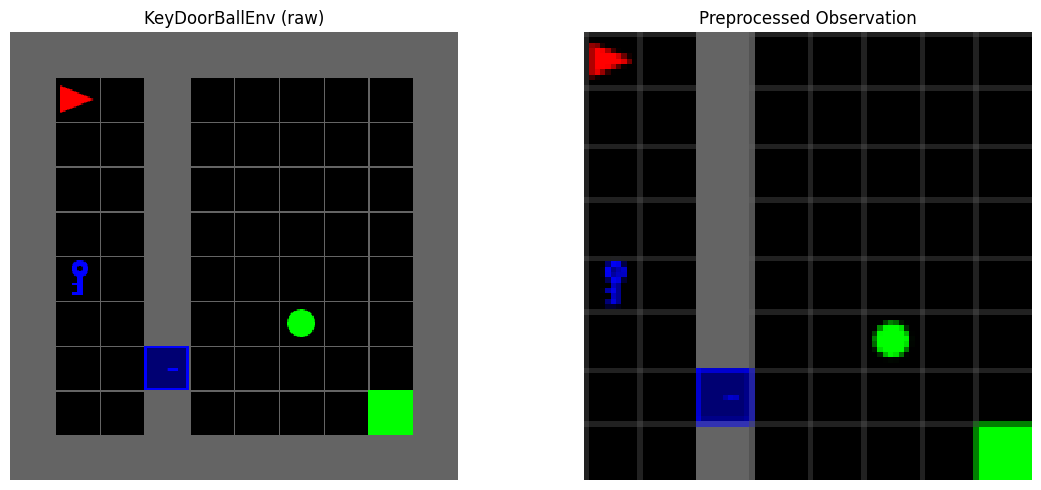

In [47]:
# Initialize environment
env = KeyDoorBallEnv(max_steps=5000, preprocess=pre_process)
obs = env.reset()[0]

print("=== KeyDoorBallEnv ===")
print(f"Action space:       {env.action_space}")
print(f"Number of actions:  {env.action_space.n}")
print(f"Observation space:  {env.observation_space}  (ensure it matches preprocessing output)")
print(f"Observation shape:  {obs.shape}")
print(f"Agent direction:    {env.agent_dir}")
print(f"Agent position:     {env.agent_pos}")
print(f"Goal position:      {env.goal_pos}")
print(f"Carrying key:       {env.is_carrying_key()}")
print(f"Door open:          {env.is_door_open()}")
print(f"Carrying ball:      {env.is_carrying_ball()}")

# Side-by-side view of raw and preprocessed observations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(env.render())
axes[0].set_title("KeyDoorBallEnv (raw)")
axes[0].axis("off")
axes[1].imshow(obs.squeeze(), cmap="gray")
axes[1].set_title("Preprocessed Observation")
axes[1].axis("off")
plt.tight_layout()
plt.show()

In [48]:
# COLAB ONLY — restore before submission (/content/ path doesn't exist on macOS)
# # Random action rollout + video
# max_steps = 100
# env = KeyDoorBallEnv(max_steps=max_steps, preprocess=pre_process)
# num_actions = env.action_space.n
# obs = env.reset()[0]
# video_filename = "/content/KeyDoorBallEnv_random.mp4"
#
# with imageio.get_writer(video_filename, fps=10) as video:
#     obs, _ = env.reset()
#     done = False
#     total_reward = 0
#     for step in range(max_steps):
#         action = random.randint(0, num_actions - 1)
#         obs, reward, terminated, truncated, _ = env.step(action)
#         done = terminated or truncated
#         total_reward += reward
#         video.append_data(env.render())
#         if done:
#             break
#
# # Print episode summary
# print("=== Episode Summary ===")
# print(f"Steps:         {step + 1}")
# print(f"Total reward:  {total_reward:.3f}")
# print(f"Terminated:    {terminated}")
# print(f"Truncated:     {truncated}")
# print()
# print("=== Environment Status (End of Episode) ===")
# print(f"Agent position:  {env.agent_pos}")
# print(f"Carrying key:    {env.is_carrying_key()}")
# print(f"Door open:       {env.is_door_open()}")
# print(f"Carrying ball:   {env.is_carrying_ball()}")
#
# embed_mp4(video_filename)

# 1. Networks

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def obs_to_tensor(obs, device):
    """
    Convert a preprocessed numpy observation to a batched tensor in (N, C, H, W) format.
    Normalises uint8 pixels from [0, 255] to [0, 1] — critical for CNN convergence
    (Kaiming-initialised weights assume ~unit-variance inputs).

    Args:
        obs: numpy array of shape (H, W, C), e.g. (84, 84, 3), dtype uint8
        device: torch device

    Returns:
        Tensor of shape (1, C, H, W) on the given device, values in [0, 1]
    """
    # (H, W, C) -> (C, H, W), convert to float32 and normalise to [0, 1]
    t = torch.from_numpy(obs.transpose(2, 0, 1).astype(np.float32, copy=False))
    t = t.mul_(1.0 / 255.0)  # in-place: [0,255] -> [0,1]
    return t.unsqueeze(0).to(device)


class CNNFeatureExtractor(nn.Module):
    """
    CNN for extracting features from preprocessed grid-world images.

    Uses small 3×3 kernels with stride 2 to capture fine spatial detail
    (agent triangle, goal square) in the sparse 84×84 grayscale images.
    Inputs are expected in [0, 1] (via obs_to_tensor normalisation).

    Input:  (batch, 3, 84, 84)  — channels-first RGB, values in [0, 1]
    Output: (batch, feature_dim)

    Architecture:
        Conv1 + ReLU: 32 × 3×3, stride 2, pad 1 → 42×42
        Conv2 + ReLU: 64 × 3×3, stride 2, pad 1 → 21×21
        Conv3 + ReLU: 64 × 3×3, stride 2, pad 1 → 11×11
        Conv4 + ReLU: 64 × 3×3, stride 2, pad 1 →  6×6
        Flatten → 2304
        FC + ReLU → feature_dim
    """

    def __init__(self, input_channels=3, feature_dim=256):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, stride=2, padding=1)

        # 64 * 6 * 6 = 2304  (84 → 42 → 21 → 11 → 6)
        self.fc = nn.Linear(64 * 6 * 6, feature_dim)
        self.feature_dim = feature_dim

    def forward(self, x):
        """
        Args:
            x: Float tensor of shape (batch, C, H, W).

        Returns:
            Feature vector of shape (batch, feature_dim)
        """
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        return x


class ActorCriticNetwork(nn.Module):
    """
    Actor-Critic network with a shared CNN backbone and two heads:
        - Actor  (policy head): outputs action logits
        - Critic (value head):  outputs scalar state value V(s)

    Sharing the backbone means the CNN learns features useful for both
    action selection and value estimation, which is more sample-efficient.

    Input:  (batch, 3, 84, 84)
    Output: logits (batch, num_actions), value (batch, 1)
    """

    def __init__(self, num_actions, feature_dim=256):
        super().__init__()

        self.cnn = CNNFeatureExtractor(input_channels=3, feature_dim=feature_dim)
        self.policy_head = nn.Linear(feature_dim, num_actions)
        self.value_head = nn.Linear(feature_dim, 1)

    def forward(self, x):
        """
        Returns:
            logits: (batch, num_actions) — raw unnormalised action scores
            value:  (batch, 1) — estimated state value V(s)
        """
        features = self.cnn(x)
        logits = self.policy_head(features)
        value = self.value_head(features)
        return logits, value

    def act(self, obs, device):
        """
        Select an action for a single observation (keeps grad for training).

        Returns:
            action: int
            log_prob: scalar tensor shape () (with grad)
            entropy: scalar tensor shape ()
            value: scalar tensor shape () (with grad)
        """
        obs_t = obs_to_tensor(obs, device)
        logits, value = self.forward(obs_t)

        # squeeze(0) removes the batch dim so Categorical has batch_shape ()
        # → log_prob, entropy, sample all return true scalars (shape ())
        dist = torch.distributions.Categorical(logits=logits.squeeze(0))
        action = dist.sample()

        return (
            action.item(),
            dist.log_prob(action),   # shape ()
            dist.entropy(),          # shape ()
            value.squeeze(),         # (1,1) -> scalar ()
        )

    @torch.no_grad()
    def get_value(self, obs, device):
        """Get V(s) for a single observation (no grad, for bootstrapping)."""
        obs_t = obs_to_tensor(obs, device)
        _, value = self.forward(obs_t)
        return value.squeeze().item()

# 2. A2C Algorithm

In [50]:
import torch.optim as optim


def train_actor_critic(
    env_class,
    num_episodes=10000,
    max_steps=200,
    lr=0.0007,
    gamma=0.99,
    entropy_coef=0.01,
    value_coef=0.5,
    n_steps=5,
    max_grad_norm=0.5,
    print_every=100,
    device=None,
    tile_size=10,
):
    """
    Train an Advantage Actor-Critic (A2C) agent.

    Uses n-step returns for advantage estimation:
        A_t = (Σ_{k=0}^{n-1} γ^k r_{t+k}) + γ^n V(s_{t+n}) - V(s_t)

    Args:
        env_class: Environment class (SimpleGridEnv or KeyDoorBallEnv)
        num_episodes: Total training episodes
        max_steps: Max steps per episode
        lr: Learning rate for Adam
        gamma: Discount factor
        entropy_coef: Entropy bonus weight (exploration)
        value_coef: Critic loss weight (relative to actor loss)
        n_steps: Number of steps for n-step returns
        max_grad_norm: Gradient clipping norm
        print_every: Logging frequency
        device: torch device
        tile_size: Tile size for env rendering (smaller = faster)

    Returns:
        agent: TrainedActorCriticAgent wrapper
        history: dict with episode_rewards, episode_steps, avg_entropy,
                 actor_losses, critic_losses
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ---- environment & network ----
    env = env_class(preprocess=pre_process, max_steps=max_steps, tile_size=tile_size)
    num_actions = env.action_space.n

    model = ActorCriticNetwork(num_actions).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # ---- bookkeeping ----
    history = {
        "episode_rewards": [],
        "episode_steps": [],
        "running_reward": 0.0,
        "avg_entropy": [],
        "actor_losses": [],
        "critic_losses": [],
    }

    print(f"Training A2C on {env_class.__name__}")
    print(f"Episodes: {num_episodes}, Max steps: {max_steps}, n_steps: {n_steps}")
    print(f"LR: {lr}, Gamma: {gamma}, Entropy coef: {entropy_coef}")
    print("=" * 60)

    update_count = 0

    for episode in range(num_episodes):
        obs, _ = env.reset()
        episode_reward = 0.0

        # n-step buffers (collected within the episode, flushed every n_steps)
        step_log_probs = []
        step_values = []
        step_rewards = []
        step_entropies = []

        for step in range(max_steps):
            action, log_prob, entropy, value = model.act(obs, device)

            next_obs, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward

            step_log_probs.append(log_prob)
            step_values.append(value)
            step_rewards.append(reward)
            step_entropies.append(entropy)

            done = terminated or truncated

            # ---- update every n_steps or at episode end ----
            if len(step_rewards) == n_steps or done:
                # Bootstrap value for non-terminal states
                if done:
                    R = 0.0
                else:
                    R = model.get_value(next_obs, device)

                # Compute n-step returns (backward through buffer)
                returns = []
                for r in reversed(step_rewards):
                    R = r + gamma * R
                    returns.append(R)
                returns.reverse()

                returns_t = torch.tensor(returns, dtype=torch.float32, device=device)
                log_probs_t = torch.stack(step_log_probs)
                values_t = torch.stack(step_values).squeeze(-1)
                entropies_t = torch.stack(step_entropies)

                # Advantage = returns - V(s)  (no grad through returns)
                advantages = returns_t - values_t.detach()
                # Normalise so actor gradient isn't dwarfed by entropy term
                if advantages.numel() > 1:
                    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

                # Losses
                actor_loss = -(log_probs_t * advantages).mean()
                critic_loss = (returns_t.detach() - values_t).pow(2).mean()
                entropy_bonus = entropies_t.mean()

                loss = actor_loss + value_coef * critic_loss - entropy_coef * entropy_bonus

                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
                optimizer.step()

                update_count += 1
                history["actor_losses"].append(actor_loss.item())
                history["critic_losses"].append(critic_loss.item())
                history["avg_entropy"].append(entropy_bonus.item())

                # Clear buffers
                step_log_probs = []
                step_values = []
                step_rewards = []
                step_entropies = []

            obs = next_obs
            if done:
                break

        # ---- record episode stats ----
        history["episode_rewards"].append(episode_reward)
        history["episode_steps"].append(step + 1)

        if history["running_reward"] == 0.0:
            history["running_reward"] = episode_reward
        else:
            history["running_reward"] = (
                0.95 * history["running_reward"] + 0.05 * episode_reward
            )

        # ---- logging ----
        if (episode + 1) % print_every == 0:
            avg_reward = np.mean(history["episode_rewards"][-print_every:])
            avg_steps = np.mean(history["episode_steps"][-print_every:])
            recent_entropy = (
                np.mean(history["avg_entropy"][-50:])
                if history["avg_entropy"] else 0.0
            )
            print(
                f"Episode {episode + 1:5d} | "
                f"Avg Reward: {avg_reward:8.3f} | "
                f"Avg Steps: {avg_steps:6.1f} | "
                f"Entropy: {recent_entropy:.3f} | "
                f"Running: {history['running_reward']:8.3f}"
            )

    print("=" * 60)
    print("Training complete!")
    recent = min(print_every, len(history["episode_rewards"]))
    print(
        f"Last {recent} episodes — "
        f"Avg Reward: {np.mean(history['episode_rewards'][-recent:]):.3f}, "
        f"Avg Steps: {np.mean(history['episode_steps'][-recent:]):.1f}"
    )

    env.close()
    agent = TrainedActorCriticAgent(model, device)
    return agent, history


class TrainedActorCriticAgent:
    """
    Wrapper around a trained ActorCriticNetwork for evaluation.

    Usage:
        action = agent.select_action(obs)          # greedy (argmax)
        action = agent.select_action(obs, greedy=False)  # stochastic
    """

    def __init__(self, model, device):
        self.model = model
        self.device = device

    @torch.no_grad()
    def select_action(self, obs, greedy=True):
        obs_t = obs_to_tensor(obs, self.device)
        logits, _ = self.model(obs_t)

        if greedy:
            return logits.argmax(dim=-1).item()
        else:
            dist = torch.distributions.Categorical(logits=logits)
            return dist.sample().item()

# 3. Utils

In [51]:
import os


# ---------------------------------------------------------------------------
# Plotting
# ---------------------------------------------------------------------------

def plot_training_history(history, title="Training History", save_path=None):
    """
    Plot reward and step curves from a training history dict.

    Expects *history* to contain at least:
        - episode_rewards : list[float]
        - episode_steps   : list[int]

    Optionally plots entropy if history contains:
        - avg_entropy : list[float]

    Args:
        history: dict returned by a training function
        title: plot super-title
        save_path: if provided, save the figure to this path instead of plt.show()
    """
    has_entropy = "avg_entropy" in history and len(history["avg_entropy"]) > 0
    ncols = 3 if has_entropy else 2
    fig, axes = plt.subplots(1, ncols, figsize=(5 * ncols, 4))

    window = min(100, max(1, len(history["episode_rewards"]) // 10))

    # ---- rewards ----
    ax = axes[0]
    ax.plot(history["episode_rewards"], alpha=0.3, label="Per episode")
    if len(history["episode_rewards"]) >= window:
        smoothed = np.convolve(
            history["episode_rewards"],
            np.ones(window) / window,
            mode="valid",
        )
        ax.plot(
            range(window - 1, len(history["episode_rewards"])),
            smoothed,
            label=f"{window}-ep avg",
        )
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    ax.set_title(f"{title} — Rewards")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # ---- steps ----
    ax = axes[1]
    ax.plot(history["episode_steps"], alpha=0.3, label="Per episode")
    if len(history["episode_steps"]) >= window:
        smoothed = np.convolve(
            history["episode_steps"],
            np.ones(window) / window,
            mode="valid",
        )
        ax.plot(
            range(window - 1, len(history["episode_steps"])),
            smoothed,
            label=f"{window}-ep avg",
        )
    ax.set_xlabel("Episode")
    ax.set_ylabel("Steps")
    ax.set_title(f"{title} — Steps per Episode")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # ---- entropy (optional) ----
    if has_entropy:
        ax = axes[2]
        ax.plot(history["avg_entropy"])
        ax.set_xlabel("Update step")
        ax.set_ylabel("Entropy")
        ax.set_title(f"{title} — Policy Entropy")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"Saved training plot to: {save_path}")
        plt.close()
    else:
        plt.show()


# ---------------------------------------------------------------------------
# Evaluation
# ---------------------------------------------------------------------------

def evaluate_agent(agent, env_class, num_episodes=100, max_steps=200,
                   tile_size=10):
    """
    Evaluate a trained agent over multiple episodes.

    The agent must expose ``select_action(obs) -> int``.

    Args:
        agent: trained agent (or None for random baseline)
        env_class: environment class (SimpleGridEnv / KeyDoorBallEnv)
        num_episodes: number of evaluation episodes
        max_steps: max steps per episode
        tile_size: tile size for rendering (smaller = faster)

    Returns:
        dict with keys: num_episodes, avg_reward, std_reward, avg_steps,
        std_steps, success_rate, min_steps, max_steps, all_rewards, all_steps
    """
    env = env_class(preprocess=pre_process, max_steps=max_steps, tile_size=tile_size)

    episode_rewards = []
    episode_steps = []
    successes = 0

    for ep in range(num_episodes):
        obs, _ = env.reset()
        total_reward = 0.0

        for step in range(max_steps):
            if agent is None:
                action = env.action_space.sample()
            else:
                action = agent.select_action(obs)

            obs, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

            if terminated:
                successes += 1
                break
            if truncated:
                break

        episode_rewards.append(total_reward)
        episode_steps.append(step + 1)

        # Progress bar
        done = ep + 1
        pct = done / num_episodes
        bar_len = 30
        filled = int(bar_len * pct)
        bar = "█" * filled + "░" * (bar_len - filled)
        print(
            f"\rEvaluating: |{bar}| {done}/{num_episodes} "
            f"({pct*100:.0f}%) success so far: {successes}/{done}",
            end="",
            flush=True,
        )

    print()  # newline after progress bar
    env.close()

    return {
        "num_episodes": num_episodes,
        "avg_reward": np.mean(episode_rewards),
        "std_reward": np.std(episode_rewards),
        "avg_steps": np.mean(episode_steps),
        "std_steps": np.std(episode_steps),
        "success_rate": successes / num_episodes,
        "min_steps": int(np.min(episode_steps)),
        "max_steps": int(np.max(episode_steps)),
        "all_rewards": episode_rewards,
        "all_steps": episode_steps,
    }


def print_evaluation_results(results, title="Evaluation Results"):
    """Print formatted evaluation metrics."""
    print("=" * 60)
    print(f" {title}")
    print("=" * 60)
    print(f"  Episodes evaluated:  {results['num_episodes']}")
    print(f"  Success rate:        {results['success_rate']*100:.1f}%")
    print("-" * 60)
    print(f"  Average reward:      {results['avg_reward']:.3f} +/- {results['std_reward']:.3f}")
    print(f"  Average steps:       {results['avg_steps']:.1f} +/- {results['std_steps']:.1f}")
    print(f"  Step range:          [{results['min_steps']}, {results['max_steps']}]")
    print("=" * 60)


# ---------------------------------------------------------------------------
# Video recording
# ---------------------------------------------------------------------------

def record_video(agent, env_class, filename, num_episodes=1, max_steps=200,
                  fps=10):
    """
    Record an agent playing and save as GIF.

    Args:
        agent: trained agent with select_action(obs), or None for random
        env_class: environment class
        filename: output GIF path (e.g. "outputs/agent.gif")
        num_episodes: episodes to record
        max_steps: max steps per episode
        fps: frames per second for the GIF

    Returns:
        (total_reward, total_steps)
    """
    # Use full tile_size=32 for crisp video frames
    env = env_class(preprocess=pre_process, max_steps=max_steps, tile_size=32)

    frames = []
    total_reward = 0.0
    total_steps = 0

    for ep in range(num_episodes):
        obs, _ = env.reset()
        frame = env.render()
        if frame is not None:
            frames.append(np.array(frame))

        for step in range(max_steps):
            if agent is None:
                action = env.action_space.sample()
            else:
                action = agent.select_action(obs)

            obs, reward, terminated, truncated, _ = env.step(action)
            frame = env.render()
            if frame is not None:
                frames.append(np.array(frame))
            total_reward += reward
            total_steps += 1

            if terminated or truncated:
                break

    env.close()

    if not frames:
        print("Warning: no frames captured, skipping video save.")
        return total_reward, total_steps

    # duration in ms per frame (imageio v2.9+ uses duration instead of fps)
    duration_ms = 1000.0 / fps

    out_dir = os.path.dirname(filename)
    if out_dir:
        os.makedirs(out_dir, exist_ok=True)
    imageio.mimsave(filename, frames, duration=duration_ms, loop=0)
    print(f"Video saved: {filename}  ({len(frames)} frames, {fps} fps)")
    print(f"  Episodes: {num_episodes}, Total steps: {total_steps}, Total reward: {total_reward:.2f}")

    return total_reward, total_steps

# 4. SimpleGridEnv Experiment

In [52]:
# ── Reproducibility ──────────────────────────────────────────────────────────
SEED = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ── A2C hyperparameters ─────────────────────────────────────────────────────
A2C_CONFIG = {
    "num_episodes": 30000,
    "max_steps": 100,          # random agent finds goal ~17 % of the time
    "lr": 0.0003,              # lower LR for stability (A2C is noisy)
    "gamma": 0.95,
    "entropy_coef": 0.02,      # lighter entropy to let policy commit
    "value_coef": 0.5,
    "n_steps": 20,             # longer horizon covers more of the episode
    "max_grad_norm": 0.5,
    "print_every": 500,
    "tile_size": 10,
}

# ── Train ────────────────────────────────────────────────────────────────────
a2c_agent, a2c_history = train_actor_critic(
    env_class=SimpleGridEnv,
    device=device,
    **A2C_CONFIG,
)

# ── Store results (dict keyed by algorithm name — easy to add DQN later) ────
simplegrid_results = {
    "A2C": {"agent": a2c_agent, "history": a2c_history, "config": A2C_CONFIG},
    # "DQN": {"agent": dqn_agent, "history": dqn_history, "config": DQN_CONFIG},  # ← Dor adds this
}

Device: cpu
Training A2C on SimpleGridEnv
Episodes: 30000, Max steps: 100, n_steps: 20
LR: 0.0003, Gamma: 0.95, Entropy coef: 0.02
Episode   500 | Avg Reward:   -0.721 | Avg Steps:   97.5 | Entropy: 0.548 | Running:   -0.952
Episode  1000 | Avg Reward:   -0.965 | Avg Steps:   99.7 | Entropy: 0.759 | Running:   -0.997
Episode  1500 | Avg Reward:   -0.974 | Avg Steps:   99.8 | Entropy: 0.562 | Running:   -0.988
Episode  2000 | Avg Reward:   -0.840 | Avg Steps:   98.7 | Entropy: 0.813 | Running:   -0.328
Episode  2500 | Avg Reward:   -0.734 | Avg Steps:   97.8 | Entropy: 0.813 | Running:   -0.568
Episode  3000 | Avg Reward:   -0.398 | Avg Steps:   92.9 | Entropy: 0.658 | Running:    0.142
Episode  3500 | Avg Reward:   -0.367 | Avg Steps:   92.7 | Entropy: 0.653 | Running:   -0.673
Episode  4000 | Avg Reward:    0.365 | Avg Steps:   84.9 | Entropy: 0.533 | Running:    0.913
Episode  4500 | Avg Reward:    0.771 | Avg Steps:   77.7 | Entropy: 0.476 | Running:    0.128
Episode  5000 | Avg Rew

## Training Curves

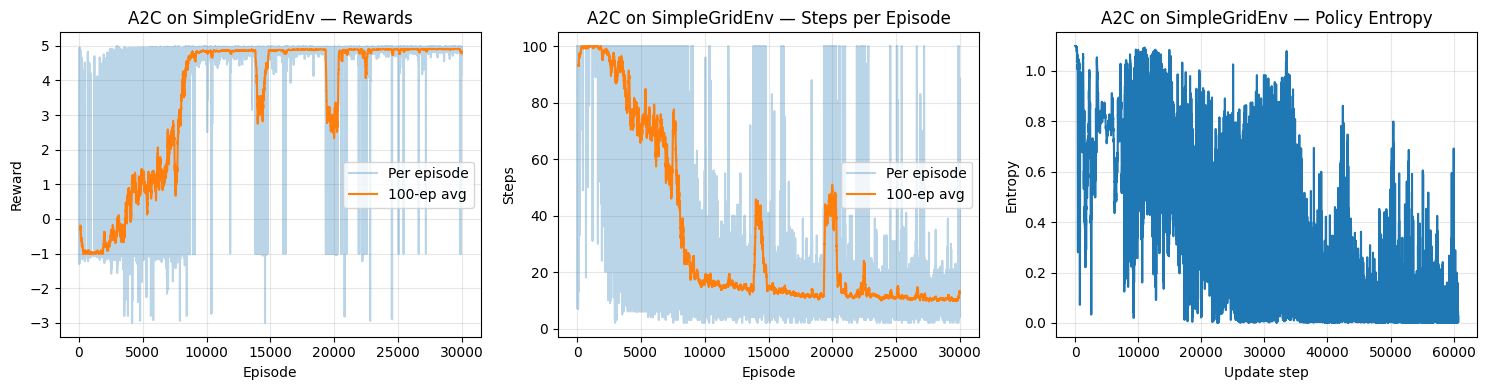

In [53]:
# ── Individual training curves per algorithm ─────────────────────────────────
for algo_name, data in simplegrid_results.items():
    plot_training_history(data["history"], title=f"{algo_name} on SimpleGridEnv")

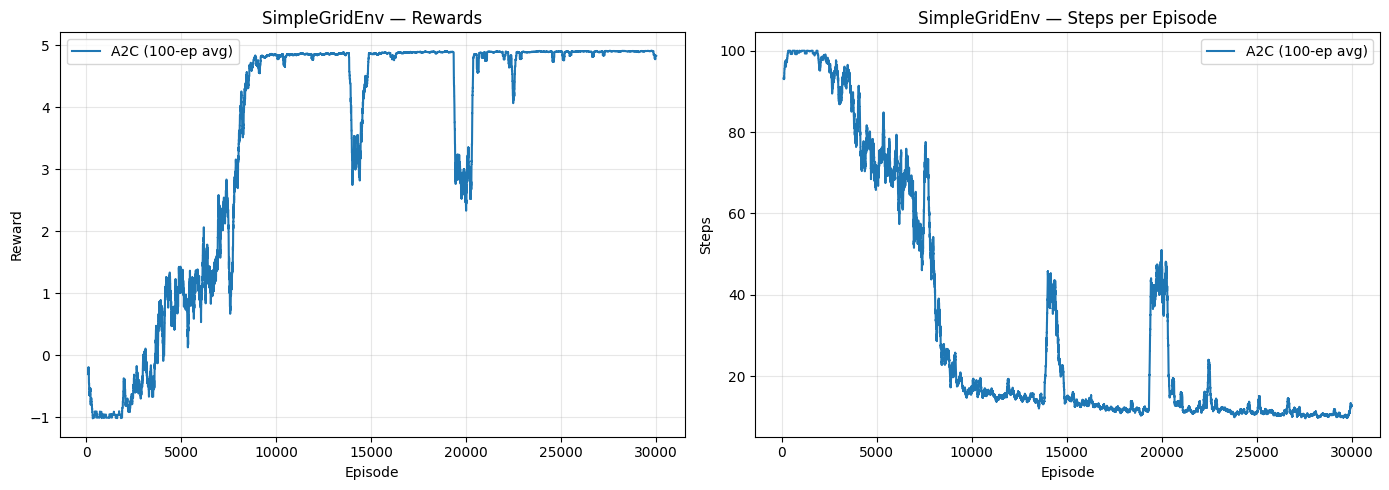

In [54]:
# ── Comparison overlay (rewards + steps) ─────────────────────────────────────
# Overlays all algorithms in simplegrid_results on the same axes.
# Currently only A2C; when DQN is added to the dict, it appears automatically.

SMOOTHING_WINDOW = 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for algo_name, data in simplegrid_results.items():
    rewards = data["history"]["episode_rewards"]
    steps   = data["history"]["episode_steps"]

    # smoothed rewards
    if len(rewards) >= SMOOTHING_WINDOW:
        kernel = np.ones(SMOOTHING_WINDOW) / SMOOTHING_WINDOW
        sm_rewards = np.convolve(rewards, kernel, mode="valid")
        sm_steps   = np.convolve(steps,   kernel, mode="valid")
        x = range(SMOOTHING_WINDOW - 1, len(rewards))
        axes[0].plot(x, sm_rewards, label=f"{algo_name} ({SMOOTHING_WINDOW}-ep avg)")
        axes[1].plot(x, sm_steps,   label=f"{algo_name} ({SMOOTHING_WINDOW}-ep avg)")
    else:
        axes[0].plot(rewards, label=algo_name)
        axes[1].plot(steps,   label=algo_name)

axes[0].set_xlabel("Episode"); axes[0].set_ylabel("Reward")
axes[0].set_title("SimpleGridEnv — Rewards"); axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel("Episode"); axes[1].set_ylabel("Steps")
axes[1].set_title("SimpleGridEnv — Steps per Episode"); axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Evaluation (last 100 episodes)

In [55]:
for algo_name, data in simplegrid_results.items():
    results = evaluate_agent(
        agent=data["agent"],
        env_class=SimpleGridEnv,
        num_episodes=100,
        max_steps=data["config"]["max_steps"],
    )
    print_evaluation_results(results, title=f"{algo_name} on SimpleGridEnv — Evaluation")
    data["eval"] = results  # store for later comparison
    print()

Evaluating: |██████████████████████████████| 100/100 (100%) success so far: 100/100
 A2C on SimpleGridEnv — Evaluation
  Episodes evaluated:  100
  Success rate:        100.0%
------------------------------------------------------------
  Average reward:      4.908 +/- 0.029
  Average steps:       10.2 +/- 2.9
  Step range:          [4, 17]



## Video — Trained Agent

In [56]:
# Records a GIF of the trained agent (works on macOS — no Xvfb needed)
for algo_name, data in simplegrid_results.items():
    gif_path = f"simplegrid_{algo_name.lower()}_trained.gif"
    record_video(
        agent=data["agent"],
        env_class=SimpleGridEnv,
        filename=gif_path,
        num_episodes=1,
        max_steps=data["config"]["max_steps"],
    )

Video saved: simplegrid_a2c_trained.gif  (4 frames, 10 fps)
  Episodes: 1, Total steps: 3, Total reward: 4.98
